# Load: part-of-speech-olive-cormorant

In [ ]:
import pickle
import pandas as pd

from tqdm.auto import tqdm

In [ ]:
model_name = "part-of-speech-olive-cormorant"

In [ ]:
with open("/home/eeisenst/workspace/compassionai/data-registry/processed_datasets/part-of-speech-olive/train.pkl", "rb") as f:
    train_data = pickle.load(f)
with open("/home/eeisenst/workspace/compassionai/data-registry/processed_datasets/part-of-speech-olive/test.pkl", "rb") as f:
    test_data = pickle.load(f)

In [ ]:
len(train_data), len(test_data)

In [ ]:
def _to_list_of_lists(data):
    res = []
    for example in tqdm(data):
        cur_res = ([], [])
        cur_word, cur_tag = [], set()
        for token, tag in zip(*example):
            if tag == '[MASK]':
                continue
            cur_word.append(token)
            cur_tag = cur_tag.union(set(tag.split('+')))
            if '[WORD_END]' in cur_tag:
                cur_tag = sorted(filter(lambda x: not x == '[WORD_END]', list(cur_tag)))
                cur_res[0].append(cur_word)
                cur_res[1].append('+'.join(cur_tag))
                cur_word, cur_tag = [], set()
        res.append(cur_res)
    return res

In [ ]:
train_data = _to_list_of_lists(train_data)
test_data = _to_list_of_lists(test_data)

In [ ]:
train_words = set([' '.join(map(str, word)) for words, _ in train_data for word in words])
len(list(train_words))

In [ ]:
test_words = set([' '.join(map(str, word)) for words, _ in test_data for word in words])
len(list(test_words))

In [ ]:
len(list(test_words - train_words))

In [ ]:
test_word_lens = pd.Series([len(word) for word in test_words])

In [ ]:
test_word_lens.value_counts().sort_index().plot(kind='bar', figsize=(12,8))

# Load: part-of-speech-intersyllabic-olive-cormorant

In [1]:
import pickle
import pandas as pd

In [2]:
model_name = "part-of-speech-intersyllabic-olive-cormorant"

In [3]:
with open("/home/eeisenst/workspace/compassionai/data-registry/processed_datasets/part-of-speech-intersyllabic-olive/train.pkl", "rb") as f:
    train_data = pickle.load(f)
with open("/home/eeisenst/workspace/compassionai/data-registry/processed_datasets/part-of-speech-intersyllabic-olive/test.pkl", "rb") as f:
    test_data = pickle.load(f)

In [4]:
len([t for w, _ in train_data for t in w]), len([t for w, _ in test_data for t in w])

(248521, 27705)

In [5]:
train_data[0]

([[3397, 213, 1276],
  [9901, 9927, 2981, 1296, 458],
  [17],
  [1007],
  [2171],
  [9888, 9877],
  [9955]],
 ['NOUN', 'PROPN', 'ADP', 'NOUN', 'VERB', 'PART', 'PUNCT'])

In [6]:
len(train_data), len(test_data)

(28167, 3129)

In [7]:
train_words = set([' '.join(map(str, word)) for words, _ in train_data for word in words])
len(list(train_words))

20628

In [8]:
test_words = set([' '.join(map(str, word)) for words, _ in test_data for word in words])
len(list(test_words))

5703

In [9]:
len(set(test_words - train_words))

1261

In [10]:
len(set(train_words - test_words))

16186

In [11]:
train_word_lens = pd.Series([len(word) for word in train_words])

<AxesSubplot:>

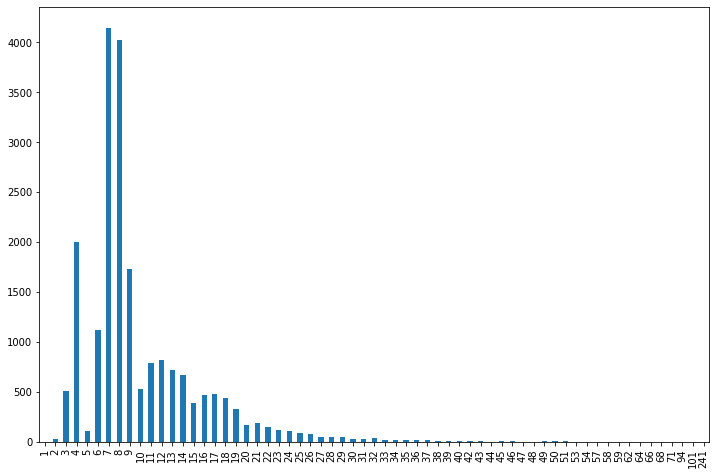

In [12]:
train_word_lens.value_counts().sort_index().plot(kind='bar', figsize=(12,8))

In [13]:
test_word_lens = pd.Series([len(word) for word in test_words])

<AxesSubplot:>

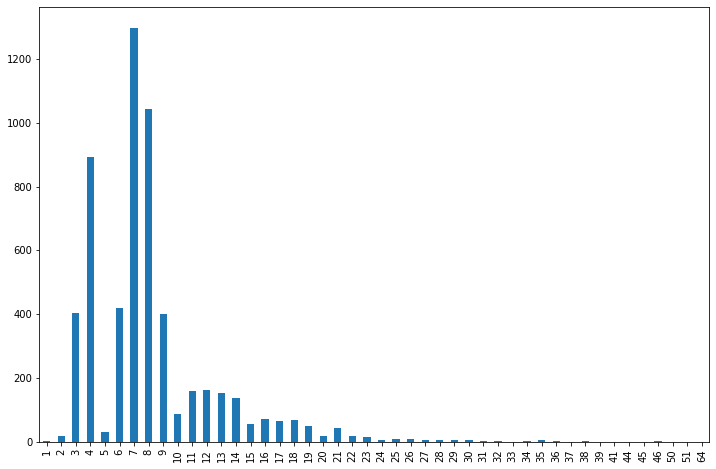

In [14]:
test_word_lens.value_counts().sort_index().plot(kind='bar', figsize=(12,8))

# Classification metrics on new words

In [15]:
from tqdm.auto import tqdm

In [16]:
from cai_manas.part_of_speech.pos_tagger import PartOfSpeechTagger

In [17]:
from sklearn.metrics import precision_recall_fscore_support

In [18]:
tagger = PartOfSpeechTagger(model_name)

In [19]:
res_tokens, res_tags, res_labels = [], [], []
for datum in tqdm(test_data):
    if len(datum[0]) == 0:
        continue
    try:
        cur_tags = tagger.predict_tokens([token for word in datum[0] for token in word])
    except:
        print(datum)
        raise Exception()
    cur_tags = [tagger.id_to_label_map[pred] for pred in cur_tags[1:-1]]
    res_tokens.append(datum[0])
    res_tags.append(cur_tags)
    seq_labels = []
    for word, word_label in zip(datum[0], datum[1]):
        seq_labels.append(word_label)
        for _ in range(len(word) - 1):
            seq_labels.append('[MASK]')
    res_labels.append(seq_labels)

  0%|          | 0/3129 [00:00<?, ?it/s]

In [20]:
label2id = {
    label.upper(): id_
    for id_, label in tagger.id_to_label_map.items()
}

## Out-of-vocabulary

In [30]:
strange_tags, strange_labels = [], []
# for test_word in tqdm(list(test_words.intersection(train_words))):
for test_word in tqdm(list(test_words - train_words)):
    test_tokens = list(map(int, test_word.split(' ')))
    for example, tags, labels in zip(res_tokens, res_tags, res_labels):
        example_str = [' '.join(map(str, word)) for word in example]
        if test_word in example_str:
            word_idx = example.index(test_tokens)
            tag_idx = sum([len(word) for word in example[:word_idx]])
            strange_tags.extend(tags[tag_idx:tag_idx+len(example[word_idx])])
            strange_labels.extend(labels[tag_idx:tag_idx+len(example[word_idx])])

  0%|          | 0/1261 [00:00<?, ?it/s]

In [31]:
strange_tags = [label2id[t.upper()] for t in strange_tags]
strange_labels = [label2id.get(l.upper(), label2id['UNK']) for l in strange_labels]

In [32]:
precision, recall, f1, support = precision_recall_fscore_support(
    strange_labels,
    strange_tags,
    labels=range(max(0, min(label2id.values())), max(label2id.values()) + 1),
    zero_division=0
)

In [33]:
res_df = {
    "tag": [],
    "Precision": [],
    "Recall": [],
    "F1": [],
    "Support": []
}
for tag, tag_precision, tag_recall, tag_f1, tag_support in zip(
    [tagger.id_to_label_map.get(i, 'WTF') for i in range(len(f1))], precision, recall, f1, support
):
    res_df["tag"].append(tag)
    res_df["Precision"].append(tag_precision)
    res_df["Recall"].append(tag_recall)
    res_df["F1"].append(tag_f1)
    res_df["Support"].append(tag_support)
res_df = pd.DataFrame(res_df).set_index('tag').sort_values("Support", ascending=False)
res_df = res_df[res_df.index != '[MASK]']
res_df["Support"] = res_df.Support / res_df.Support.sum()
res_df.head(10)

,Precision,Recall,F1,Support
tag,,,,
NOUN,0.739943,0.878840,0.803432,0.451812
PROPN,0.695652,0.636816,0.664935,0.154973
NOUN+ADP,0.777778,0.862319,0.817869,0.106399
NOUN+PART,0.876543,0.855422,0.865854,0.063994
VERB,0.680412,0.891892,0.771930,0.057055
unk,0.565217,0.433333,0.490566,0.046261
ADJ,0.604167,0.491525,0.542056,0.045490
PROPN+ADP,0.724138,0.477273,0.575342,0.033924
PROPN+PART,0.800000,0.444444,0.571429,0.006939


In [35]:
totals_df = res_df.copy()
print("Support percentage:", totals_df.Support.sum() / res_df.Support.sum())
totals_df["Support"] = totals_df.Support / totals_df.Support.sum()
print("Weighted average precision:", (totals_df.Precision * totals_df.Support).sum())
print("Weighted average recall:", (totals_df.Recall * totals_df.Support).sum())
print("Weighted average f1:", (totals_df.F1 * totals_df.Support).sum())

Support percentage: 1.0
Weighted average precision: 0.7157682350815949
Weighted average recall: 0.7686969930609098
Weighted average f1: 0.7359868728522705


## In-vocabulary

In [36]:
in_univ_tags = [label2id[t.upper()] for ex in res_tags for t in ex]
in_univ_labels = [label2id.get(l.upper(), label2id['UNK']) for ex in res_labels for l in ex]

In [37]:
precision, recall, f1, support = precision_recall_fscore_support(
    in_univ_labels,
    in_univ_tags,
    labels=range(max(0, min(label2id.values())), max(label2id.values()) + 1),
    zero_division=0
)

In [38]:
res_df = {
    "tag": [],
    "Precision": [],
    "Recall": [],
    "F1": [],
    "Support": []
}
for tag, tag_precision, tag_recall, tag_f1, tag_support in zip(
    [tagger.id_to_label_map.get(i, 'WTF') for i in range(len(f1))], precision, recall, f1, support
):
    res_df["tag"].append(tag)
    res_df["Precision"].append(tag_precision)
    res_df["Recall"].append(tag_recall)
    res_df["F1"].append(tag_f1)
    res_df["Support"].append(tag_support)
res_df = pd.DataFrame(res_df).set_index('tag').sort_values("Support", ascending=False)
res_df = res_df[res_df.index != '[MASK]']
res_df["Support"] = res_df.Support / res_df.Support.sum()
res_df.head(10)

,Precision,Recall,F1,Support
tag,,,,
NOUN,0.945249,0.950014,0.947626,0.250568
PART,0.984898,0.980253,0.982570,0.122469
ADP,0.989025,0.991201,0.990111,0.114853
PUNCT,0.999680,0.998082,0.998881,0.112940
VERB,0.962608,0.967088,0.964842,0.108572
NOUN+ADP,0.944277,0.960920,0.952526,0.047103
CCONJ,0.988701,0.991100,0.989899,0.044613
NOUN+PART,0.963198,0.938195,0.950532,0.029201
DET,0.997015,0.994048,0.995529,0.024256


In [42]:
totals_df = res_df.copy()
print("Support percentage:", totals_df.Support.sum() / res_df.Support.sum())
totals_df["Support"] = totals_df.Support / totals_df.Support.sum()
print("Weighted average precision:", (totals_df.Precision * totals_df.Support).sum())
print("Weighted average recall:", (totals_df.Recall * totals_df.Support).sum())
print("Weighted average f1:", (totals_df.F1 * totals_df.Support).sum())

Support percentage: 1.0
Weighted average precision: 0.9604637473470722
Weighted average recall: 0.9539794260963725
Weighted average f1: 0.9563007618005318
